# Goal

The aim of this notebook is to know in deep the current situation of the Irish Real State Market and figure out what are the most promissing variables in order to infer the price.

# Import Libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

import pylab
from scipy.stats import kstest
import scipy.stats as stats
from scipy.stats import normaltest

import ppscore as pps
import random
from sklearn.tree import DecisionTreeRegressor



from daftpy.daftfeanalysis import (missing_values, frequencies, pct_method, 
                                   iqr_method, std_method, outlier_bool, drop_outliers, 
                                  print_limits, common_ix, drop_all_outliers,
                                  check_transformations)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
import warnings

def fxn():
    warnings.warn("user", UserWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

# Load Data

In [4]:
sale = pd.read_csv('data_available/sale_post_geosp_fe.csv', sep=',', parse_dates=['entered_renewed', 'scraping_date'])
sale.shape

(7661, 24)

In [5]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7661 entries, 0 to 7660
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   daft_id          7661 non-null   int64         
 1   url              7661 non-null   object        
 2   name             7661 non-null   object        
 3   price            7661 non-null   float64       
 4   sale_type        7661 non-null   object        
 5   floor_area       7661 non-null   int64         
 6   psr              7645 non-null   float64       
 7   ber              7466 non-null   object        
 8   entered_renewed  7661 non-null   datetime64[ns]
 9   views            7661 non-null   float64       
 10  type_house       7174 non-null   object        
 11  type             7661 non-null   object        
 12  scraping_date    7661 non-null   datetime64[ns]
 13  description      7660 non-null   object        
 14  latitude         7661 non-null   float64

Our target or variable response is `price`, whilst the other ones are predictors - variables that we can use to infer the price. Below you can see two tables with each variable, its meaning and a brief explanation about whether we intuitively consider it is an important predictor or not.

## Data Scraped From Daft.ie

|Variable|Meaning|Importance|Reason|Example|
|:---:|:---:|:---:|:---:|:---:|
|price|House market price|High|It is the target|180000.0|
|daft_id|Ad's id|In-between|It could help us to identify a particular house if we need to|16878701|
|url|Ad's url|In-between|We can visit the ad if we need to|[https://www.daft.ie/for-sale/apartment-5-the-willows-rivercourt-drogheda-co-louth/3608666](https://www.daft.ie/for-sale/apartment-5-the-willows-rivercourt-drogheda-co-louth/3608666)|
|name|Ad's name|Low|Its sctructure is too much heterogeneous and we have coordinates|5 The Willows, Rivercourt, Drogheda, Co. Louth|
|sale_type||Low|Almost all values are the same|For Sale by Private Treaty|
|floor_area|House's floor area|High|High potencial as a predictor|106|
|psr|Advertiser's identifier|Low|It is not an important attribute of the house|2239.0|
|ber|House's energetic efficiency|In-between|No sabe no contesta|B3|
|entered_renewed|Date of entry or renewal of the ad|Low|If an ad has been published for a long time or not is impossible to know because it can have been renewed|2021-11-24 00:00:00|
|views|Number of visits to the ad|In-between|No sabe no contesta|1381.0|
|type_house|Apartment or house|High|It looks like an important attribute|apartment|
|type|Buy or rent|Low|We are analyzing houses for sale, al values are the same|buy|
|scraping_date|Date when ads were scraped|Low|All values are the same|2021-11-25 00:00:00|
|description|Ad's description|In-between||...|
|latitude|House's latitude|High|Provides information about location|53.715574|
|longitude|House's longitude|High|Provides information about location|-6.371515|
|bedroom|Number of bedrooms|High|It looks like an important attribute of a house|2|
|bathroom|Number of bathrooms|High|It looks like an important attribute of a house|2|
|plus_info|More info in a word|Low|I don't know why but it doesn't look like something important|Detached|

## Data From Feature Engineering Methods

|Variable|Meaning|Importance|Reason|Example|
|:---:|:---:|:---:|:---:|:---:|
|postcode|It is the eircode||||
|state_district||Low|||
|city_district||Low|||
|place |Town or city|High|||
|code|Routing key|In-between|I think it would be the same effect than the variable 'place'||

# The Ireland's Real Estate Market

## Introduction

Agnadir algo de historia, como se distribuye y un par de mpaas.

## Current Situation of the Ireland's Real Estate Market

The information and graphs here try to help us to know a little bit the Irish Real Estate Market so we can focus in that areas we think are interesting in our search of potential investment opportunities.

The next schema show this chapter's structure.

!!!!!!!!!!!!!!!!!!!!schema

### Ireland's Real Estate Market

#### Advertisements per city

To figure out the number of advertisements per city we need to aggregate those ads with different postal districts from Dublin as they are separed.

In [6]:
# To show some postal districts
sale[['place']].dropna()[sale.place.dropna().str.contains('Dublin')].sample(3)

,place
4242,Dublin 10
541,Dublin 6
4198,Dublin 1


Something similar happens to Cork city butit has sides instead postal districts.

In [7]:
# To show both side names
pd.DataFrame(sale.place.dropna()[sale.place.dropna().str.contains('Cork')].value_counts()).rename(columns={'place':'freq_abs'})

,freq_abs
Cork city southside,275
Cork city northside,118


So let's build another column changing all those values by `Dublin` or `Cork`. After doing that, we can work with this new column or the another one depending our preferences.

In [8]:
# New column from `place` called `cities`
sale['cities'] = sale.place.copy()

# Index from ads to change
ix_to_change_dublin = sale.cities.dropna()[sale.cities.dropna().str.contains('Dublin')].index
ix_to_change_cork = sale.cities.dropna()[sale.cities.dropna().str.contains('Cork')].index

# Change them
sale.loc[ix_to_change_dublin, 'cities'] = 'Dublin'
sale.loc[ix_to_change_cork, 'cities'] = 'Cork'

To figure out the number of ads per city we are going to use the relative frequencies as we only have a sample of the population - the full market.

In [9]:
# Frequency table
freq = frequencies(df=sale, variable='cities')
freq.head()

,freq_abs,freq_rel
Dublin,1829,0.24
Cork,393,0.05
Galway,198,0.03
Limerick,178,0.02
Dun Laoghaire,141,0.02


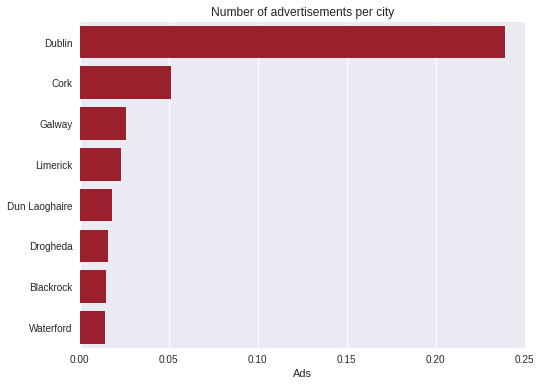

In [10]:
# Filter by cities whose frequency is greater than or equal to 50
freq_50 = freq[freq.freq_abs >= 100].copy()

fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=freq_50.freq_rel, y=freq_50.index, color='#b00b1e')

ax.set_title('Number of advertisements per city')
ax.set_xlabel('Ads')

for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
    
#ax.set_yticks([]) 
ax.tick_params(bottom=False, left=False)  

As we can see Dublin and Cork are the cities with more ads. That is not surprising as they are the bigger ones. We will focus on them later.

#### Mean price per city

In [11]:
# Create new column for square meter prices
sale['m2_price'] = sale.price / sale.floor_area

In [12]:
# Mean price by `cities` sorted in descending order
# and filter by cities with more than 100 ads
mean_price_per_city = pd.pivot_table(data=sale, 
                                        index='cities', 
                                        values=['price', 'm2_price'], 
                                        aggfunc='mean')\
                        .sort_values(by='m2_price', ascending=False)\
                        .loc[freq[freq.freq_abs > 100].index]

# Cities with more than 100 ads
mean_price_per_city

,m2_price,price
Dublin,5118.62,595192.53
Cork,3068.37,355484.61
Galway,3008.69,365257.58
Limerick,2509.39,314817.42
Dun Laoghaire,7046.50,1523296.10
Drogheda,2497.31,299887.08
Blackrock,6260.81,874034.21
Waterford,2222.42,332217.59


Let's plot both mean prices.

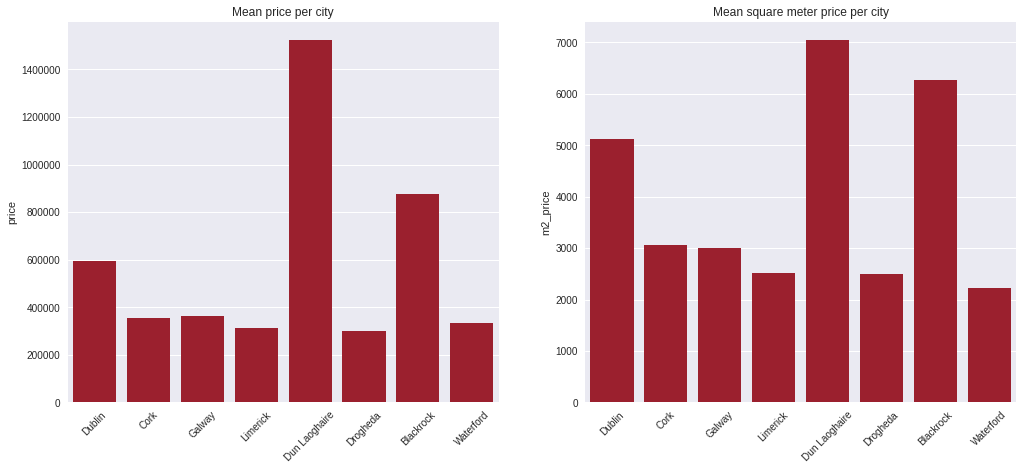

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

axs = sns.barplot(x=mean_price_per_city.price.index, 
                  y=mean_price_per_city.price, 
                  ax=axs[0], color='#b00b1e')
axs.set_title('Mean price per city')
axs.ticklabel_format(style='plain', axis='y')
axs.set_xticklabels(mean_price_per_city.price.index, 
                    rotation=45)

for location in ['left', 'bottom', 'right', 'top']:
    axs.spines[location].set_visible(False)
    
axs.tick_params(bottom=False, left=False);


axs = sns.barplot(x=mean_price_per_city.m2_price.index, 
                  y=mean_price_per_city.m2_price, 
                  color='#b00b1e') 
axs.set_title('Mean square meter price per city')
axs.ticklabel_format(style='plain', axis='y')
axs.set_xticklabels(mean_price_per_city.m2_price.index, 
                    rotation=45)
for location in ['left', 'bottom', 'right', 'top']:
    axs.spines[location].set_visible(False)
    
axs.tick_params(bottom=False, left=False);

Teniendo en cuanta ambos graficos podemos observar que que los lugares con mayores precios son Dublin, Dun Laoghaire y Blackrock. Sin embargo, tanto Dun Laoghaire como Blackrock pertenecen a Dublin. Se ha decidido estudiarlos por separado.

- Blackrock tiene un `m2_price` % inferior que Dun Laoghaire pero un `price` % menor, lo que nos indica que las casas en Blackrock son mas pequegnas que en Dun Laoghaire. Algo similar ocurre entre Dun Laoghaire y Dublin. 
- Cork y Galway, segunda y tercera ciudad por numero de habitantes, tienen precios muy similares.

#### Mean price per city by type_house

In [14]:
# Mean price by `cities` and `type_house`
# and filter by cities with more than 100 ads
mean_price_per_city_by_type_house = pd.pivot_table(data=sale, 
                                                   index=['cities', 'type_house'], 
                                                   values=['price', 'm2_price'], 
                                                   aggfunc='mean')\
                                      .sort_values(by='price', 
                                                   ascending=False)\
                                      .loc[freq[freq.freq_abs > 100].index]\
                                      .unstack()

mean_price_per_city_by_type_house

m2_price             price           
type_house    apartment   house apartment      house
cities                                              
Dublin          5210.59 5089.07 384142.56  702465.50
Cork            3449.26 3009.92 241361.70  374237.88
Galway          3373.77 2859.43 238068.18  403791.67
Limerick        2562.78 2517.95 172586.21  346974.82
Dun Laoghaire   6481.73 7157.72 583698.15 1815234.91
Drogheda        2356.28 2509.32 171702.94  325807.28
Blackrock       6084.17 6360.51 508460.26 1079928.87
Waterford       1970.78 2279.28 133947.37  373687.50

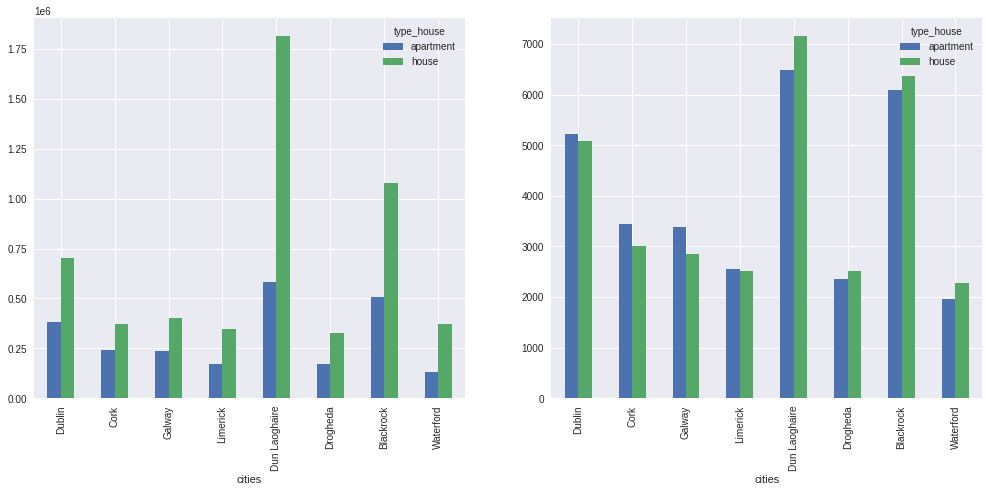

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

mean_price_per_city_by_type_house.price.plot(kind='bar', 
                                                 stacked=False, 
                                                 ax=axs[0])

mean_price_per_city_by_type_house.m2_price.plot(kind='bar', 
                                                stacked=False, 
                                                ax=axs[1]);

- `m2_price` es similar entre apartmets y houses en Dublin, Dun Laoghaire y Blackrock. Sin embargo los precios de las houses son mucho mas caras en los tres sitios, lo que nos indica que su tamagno es superior. 
- En Cork, asi como en Dublin, el `m2_price` de los apartments es un poco superior pero las casas son mas caras, lo que significa que se repite el mismo patron. 

### Dublin's Real Estate Market

We will need postal district's data if we want to dig a little into Dublin's Real Estate Market.

#### House Mean Price Per Postal District

In [16]:
# Filter to take Dublin related information
sale_dublin = sale.dropna(subset=['place']).loc[(sale.place.dropna().str.contains('Dublin'))
                                                | (sale.place == 'Blackrock')
                                                | (sale.place == 'Dun Laoghaire')]
sale_dublin.shape

(2084, 26)

In [17]:
# Mean price by `place`
mean_price_dublin_by_postal_districts = pd.pivot_table(data=sale_dublin, 
                                                       index='place', 
                                                       values=['price', 'm2_price'], 
                                                       aggfunc='mean')\
                                          .sort_values(by='price', 
                                                       ascending=False)

mean_price_dublin_by_postal_districts.head(5)

,m2_price,price
place,,
Dun Laoghaire,7046.50,1523296.10
Dublin 6,6859.80,1174651.58
Dublin 4,7388.06,1016210.84
Blackrock,6260.81,874034.21
Dublin 2,6503.13,826590.91


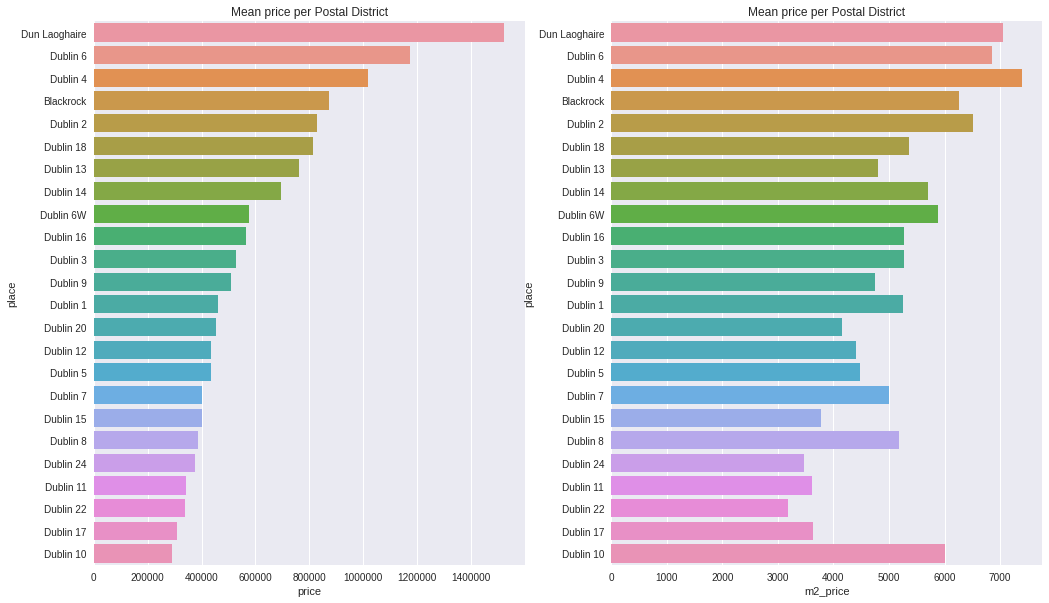

In [18]:
data = mean_price_dublin_by_postal_districts

fig, axs = plt.subplots(1, 2, figsize=(17, 10))

axs = sns.barplot(x=data.price, y=data.index, data=data, ax=axs[0])
axs.set_title('Mean price per Postal District')
axs.ticklabel_format(style='plain', axis='x');

axs = sns.barplot(x=data.m2_price, y=data.index, data=data)  #, ax=axs[1]
axs.set_title('Mean price per Postal District')
axs.ticklabel_format(style='plain', axis='x');

#### House Mean Price Per Postal District per type_house

In [19]:
# Mean price by `place` and `type_house`
mean_price_dublin_by_postal_district_and_type_house = pd.pivot_table(data=sale_dublin, 
                                                                     index=['place', 'type_house'], 
                                                                     values=['price', 'm2_price'], 
                                                                     aggfunc='mean')\
                                                        .sort_values(by='price', 
                                                                     ascending=False)\
                                                        .unstack()

mean_price_dublin_by_postal_district_and_type_house.head()

m2_price             price           
type_house apartment   house apartment      house
place                                            
Blackrock    6084.17 6360.51 508460.26 1079928.87
Dublin 1     5550.61 4782.34 451165.91  483447.96
Dublin 10    3627.45 6355.89 185000.00  294000.00
Dublin 11    3432.50 3734.97 212661.11  382877.03
Dublin 12    3922.84 4384.43 273368.75  445923.53

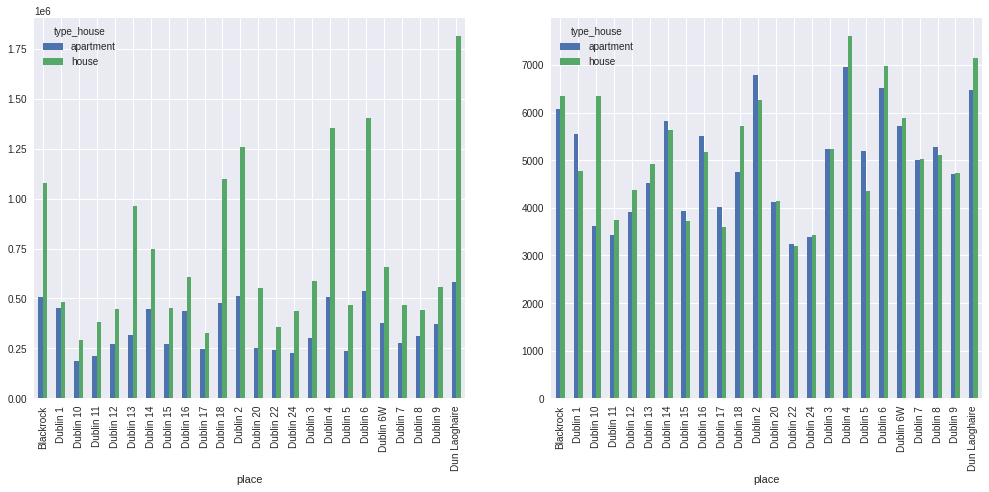

In [20]:
data = mean_price_dublin_by_postal_district_and_type_house

fig, axs = plt.subplots(1, 2, figsize=(17, 7))

data.plot(y='price', kind='bar', stacked=False, ax=axs[0]);
data.plot(y='m2_price', kind='bar', stacked=False, ax=axs[1]);

#### Floor Area per postal district and type_house

In [21]:
# Mean floor area by `place` and `type_house`
mean_floor_area_dublin_by_postal_district = pd.pivot_table(data=sale_dublin, 
                                                           index=['place', 'type_house'], 
                                                           values='floor_area', 
                                                           aggfunc='mean')\
                                              .sort_values(by='floor_area', 
                                                           ascending=False)\
                                              .unstack()

mean_floor_area_dublin_by_postal_district.head()

floor_area       
type_house  apartment  house
place                       
Blackrock       86.23 170.61
Dublin 1        83.35 101.51
Dublin 10       51.00  86.27
Dublin 11       62.78 128.05
Dublin 12       72.12 103.66

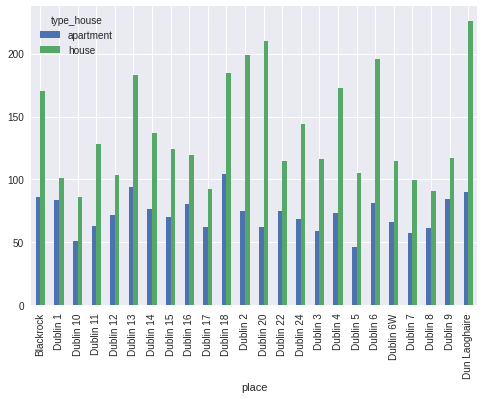

In [22]:
#fig= plt.figure(figsize=(8,6))
mean_floor_area_dublin_by_postal_district.plot(y='floor_area', kind='bar', stacked=False);

#### Number of Advertisements per PD and type_house

### Cork's Real Estate Market

#### Mean price per side

In [23]:
# Filter to take Cork related information
sale_cork = sale.dropna(subset=['place']).loc[(sale.place.dropna().str.contains('Cork'))]
sale_cork.shape

(393, 26)

In [24]:
# Mean price by `place`
mean_price_cork_by_side = pd.pivot_table(data=sale_cork, 
                                         index='place', 
                                         values=['price', 'm2_price'], 
                                         aggfunc='mean')\
                            .sort_values(by='price', 
                                         ascending=False)

mean_price_cork_by_side

,m2_price,price
place,,
Cork city southside,3213.33,371049.09
Cork city northside,2730.56,319211.44


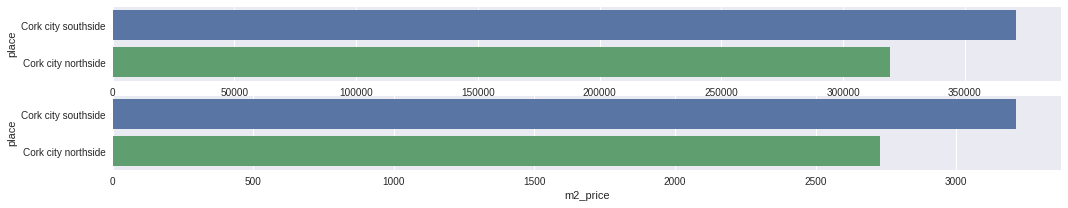

In [25]:
data = mean_price_cork_by_side

fig, axs = plt.subplots(2, 1, figsize=(17, 3))

axs = sns.barplot(x=data.price, y=data.index, data=data, ax=axs[0])
#axs.set_title('Mean price per Postal District');
axs.ticklabel_format(style='plain', axis='x');
#ax.set_xticklabels(mean_price.index, rotation=45);

axs = sns.barplot(x=data.m2_price, y=data.index, data=data)
#axs.set_title('Mean price per Postal District');
axs.ticklabel_format(style='plain', axis='x');

#### Mean price per side and type_house

In [26]:
# Mean price by `place` and `type_house`
mean_price_cork_by_side_and_type_house = pd.pivot_table(data=sale_cork, 
                                                        index=['place', 'type_house'], 
                                                        values=['price', 'm2_price'], 
                                                        aggfunc='mean')\
                                            .sort_values(by='m2_price', 
                                                         ascending=False)\
                                            #.unstack()

mean_price_cork_by_side_and_type_house

m2_price     price
place               type_house                    
Cork city southside apartment    3640.19 258216.22
                    house        3148.82 391041.85
Cork city northside apartment    2742.81 179000.00
                    house        2703.80 337203.88

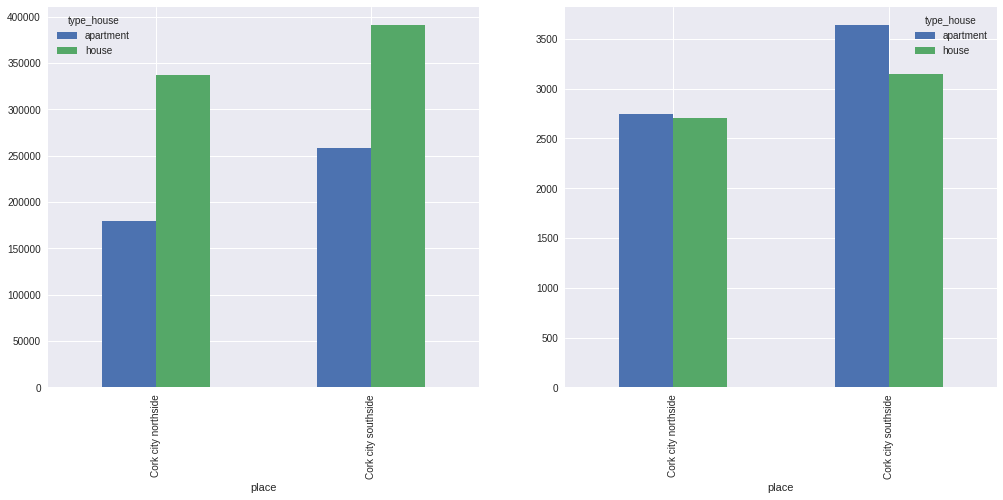

In [27]:
data = mean_price_cork_by_side_and_type_house
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

mean_price_cork_by_side_and_type_house.unstack().plot(y='price', kind='bar', stacked=False, ax=axs[0]);
mean_price_cork_by_side_and_type_house.unstack().plot(y='m2_price', kind='bar', stacked=False, ax=axs[1]);

#### Mean floor area per postal district and type_house

In [28]:
# Mean floor area by `place` and `type_house`
mean_floor_area_cork_by_side = pd.pivot_table(data=sale_cork, 
                                              index=['place', 'type_house'], 
                                              values='floor_area', aggfunc='mean')\
                                 .sort_values(by='floor_area', 
                                              ascending=False)

mean_floor_area_cork_by_side

floor_area
place               type_house            
Cork city northside house           173.44
Cork city southside house           133.51
                    apartment        74.51
Cork city northside apartment        67.00

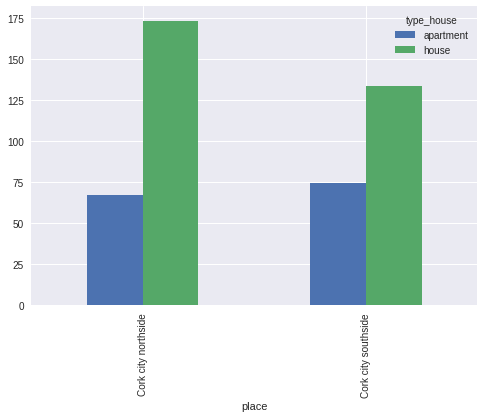

In [29]:
mean_floor_area_cork_by_side.unstack().plot(y='floor_area', kind='bar', stacked=False);

#### Number of Advertisements per side and type_house

# Distributions

## Numeric Variables

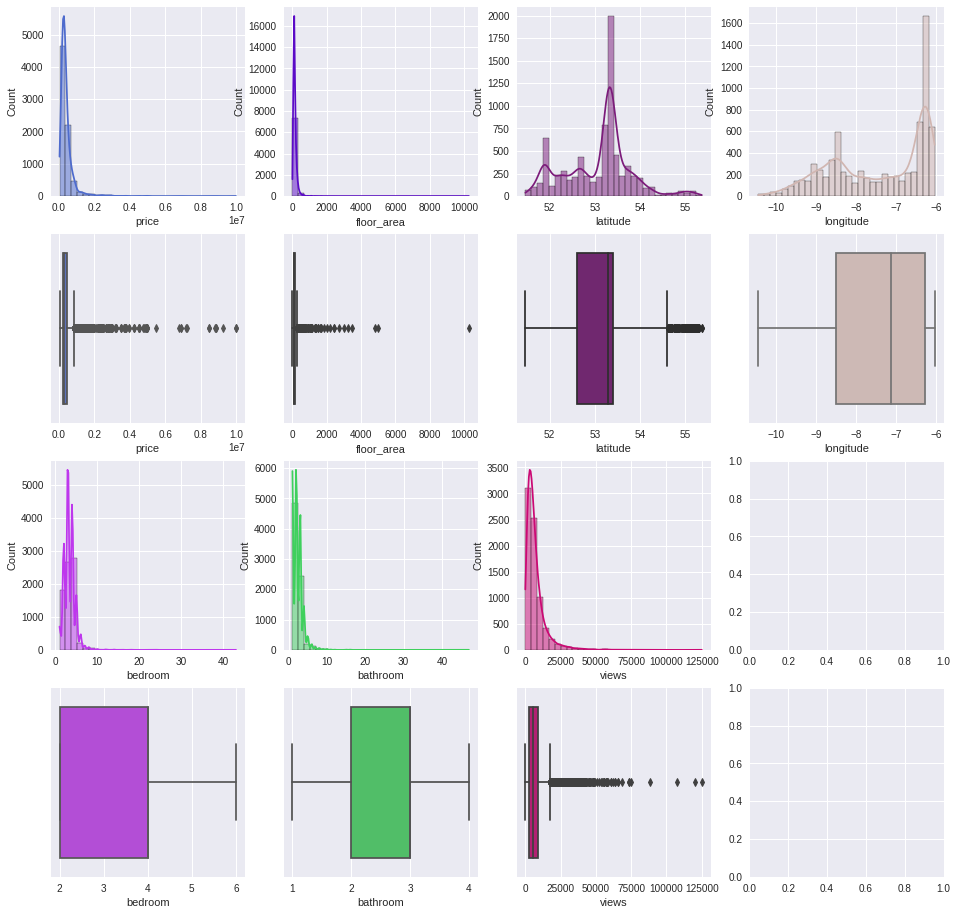

In [30]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

features = ['price', 'floor_area', 'latitude', 'longitude', 'bedroom', 'bathroom', 'views']
# Generates 7 random colors
random.seed(7)
colors = ["#" + ''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for j in range(7)]

# The below variables will be useful to provide the right axis
count = 0
row_hist = 0
row_boxp = 1
column = 0

for feature, color in zip(features, colors):
    if count >= 4:
        row_hist = 2
        row_boxp = 3
    
    sns.histplot(data=sale[feature], kde=True, bins=30, color=color, 
                 ax=axs[row_hist, column]) 
    sns.boxplot(data=sale[feature], x=sale[feature], color=color, 
                ax=axs[row_boxp, column])
    
    if column == 3:
        column = -1
        
    count += 1
    column += 1

Teorema de Tchebycheff

Probabilidad de que el precio se encuentre entre los limitis calculados para k = 2:

In [31]:
numeric_features = ['price', 'floor_area', 'views', 'bedroom', 'bathroom', 
             'latitude', 'longitude']
k = 2

skew_before_drop_out = sale[numeric_features].skew()
lim_inf = sale[numeric_features].mean() - (k * sale[numeric_features].std())
lim_sup = sale[numeric_features].mean() + (k * sale[numeric_features].std())

pd.DataFrame({'skewness': skew_before_drop_out, 
              'lim_inf': lim_inf,
              'lim_sup': lim_sup
             })

,skewness,lim_inf,lim_sup
price,8.03,-647768.94,1517692.33
floor_area,24.55,-246.86,543.48
views,4.11,-8030.83,22316.47
bedroom,5.19,0.36,6.43
bathroom,5.85,-0.61,5.22
latitude,-0.02,51.62,54.54
longitude,-0.44,-9.80,-5.06


### Outliers Detection and Elimination

Consideraremos el valor de una variable como un outlier solo cuando asi sea considerada por cada uno de los siguientes metodos.

**Percentile Based Method**
Este metodo consiste en considerar como outlier aquellos valores que sobrepasen 

**Interquartile Range Method**


**Empirical Rule**

#### Detecting `price` Outliers

In [32]:
print_limits(sale, 'price')

Percentile based method: [79000.0, 2650000.0]
Interquartile range method: [-155000.0, 845000.0]
Standard deviation method: [-1189028.2545020236, 2058951.6490980294]


In [33]:
no_out_price = drop_outliers(sale, 'price', continuous=True)

Range before: [32000.0, 10000000.0]

Limits: [-1189028.2545020236, 2650000.0]
No outliers: 7587
Outliers: 74

Range after: [32000.0, 2650000.0]
Outliers dropped: 74


#### Detecting `floor_area` Outliers

In [34]:
print_limits(sale, 'floor_area')

Percentile based method: [40.0, 628.1999999999971]
Interquartile range method: [-43.0, 293.0]
Standard deviation method: [-444.40580416866686, 741.0263497893429]


In [35]:
no_out_farea = drop_outliers(sale, 'floor_area', continuous=True)

Range before: [1, 10279]

Limits: [40.0, 741.0263497893429]
No outliers: 7545
Outliers: 116

Range after: [40, 740]
Outliers dropped: 116


#### Detecting `views` Outliers

In [36]:
print_limits(sale, 'views')

Percentile based method: [329.4000000000001, 37978.59999999989]
Interquartile range method: [-6010.5, 17481.5]
Standard deviation method: [-15616.17114093546, 29901.80382596352]


In [37]:
no_out_views = drop_outliers(sale, 'views', continuous=True)

Range before: [0.0, 125030.0]

Limits: [-15616.17114093546, 37978.59999999989]
No outliers: 7584
Outliers: 77

Range after: [0.0, 37857.0]
Outliers dropped: 77


#### Detecting `bedroom` Outliers

In [38]:
print_limits(sale, 'bedroom')

Percentile based method: [1.0, 8.0]
Interquartile range method: [1.5, 5.5]
Standard deviation method: [-1.1517999006705, 7.944124662450946]


In [39]:
no_out_bedroom = drop_outliers(sale, 'bedroom', continuous=True)

Range before: [1, 43]

Limits: [-1.1517999006705, 8.0]
No outliers: 7608
Outliers: 53

Range after: [1, 8]
Outliers dropped: 53


#### Detecting `bathroom` Outliers

In [40]:
print_limits(sale, 'bathroom')

Percentile based method: [1.0, 7.0]
Interquartile range method: [-2.0, 6.0]
Standard deviation method: [-2.0702774207641914, 6.676203540069765]


In [41]:
no_out_bathroom = drop_outliers(sale, 'bathroom', continuous=True)

Range before: [1, 47]

Limits: [-2.0702774207641914, 7.0]
No outliers: 7594
Outliers: 67

Range after: [1, 7]
Outliers dropped: 67


#### Dropping Outliers

In [42]:
index_list = [no_out_price.index, 
              no_out_farea.index,
              no_out_views.index,
              no_out_bedroom.index,
              no_out_bathroom.index]

sale_out = drop_all_outliers(df=sale, index_list=index_list)

1st and 2nd index lists: 7481 rows
3rd index list: 7427 rows
4th index list: 7383 rows
5th index list: 7357 rows
----------
Shape before dropping: (7661, 26)
Shape after dropping: (7357, 26)
304 rows/outliers dropped


In [43]:
numeric_features = ['price', 'floor_area', 'views', 'bedroom', 'bathroom', 
             'latitude', 'longitude']
k = 2

skew_before_drop_out = sale_out[numeric_features].skew()
lim_inf = sale_out[numeric_features].mean() - (k * sale_out[numeric_features].std())
lim_sup = sale_out[numeric_features].mean() + (k * sale_out[numeric_features].std())

pd.DataFrame({'skewness': skew_before_drop_out, 
              'lim_inf': lim_inf,
              'lim_sup': lim_sup
             })

,skewness,lim_inf,lim_sup
price,3.10,-209538.50,987357.74
floor_area,2.18,-21.00,288.10
views,2.10,-4856.17,17966.65
bedroom,0.51,1.01,5.60
bathroom,1.01,-0.02,4.43
latitude,-0.02,51.63,54.54
longitude,-0.43,-9.79,-5.07


### Checking Outliers Elimination Results

**The Cutoff Levels**

||Price|floor Area|Views|Bedroom|Bathroom|
|:---:|:---:|:---:|:---:|:---:|:---:|
|**Minimum**|32000.00|1|0.00|1|1|
|**Cutoff Min**|32000.00|40|0.00|1|1|
|**Cutoff Max**|2650000.00|732|46044.00|8|7|
|**Maximun**|10000000.00|10279|125030.00|43|47|

#### Price Outliers Elimination Results

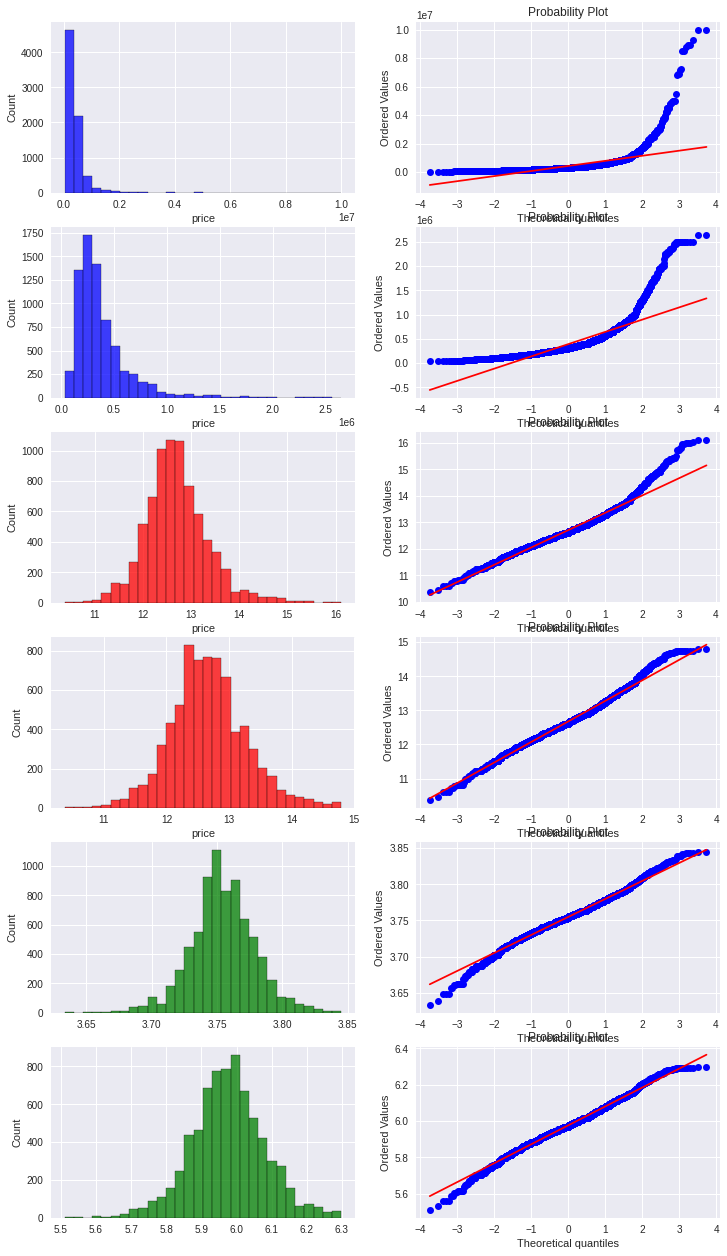

In [44]:
check_transformations(sale, sale_out, 'price')

#### Floor Area Outliers Elimination Results

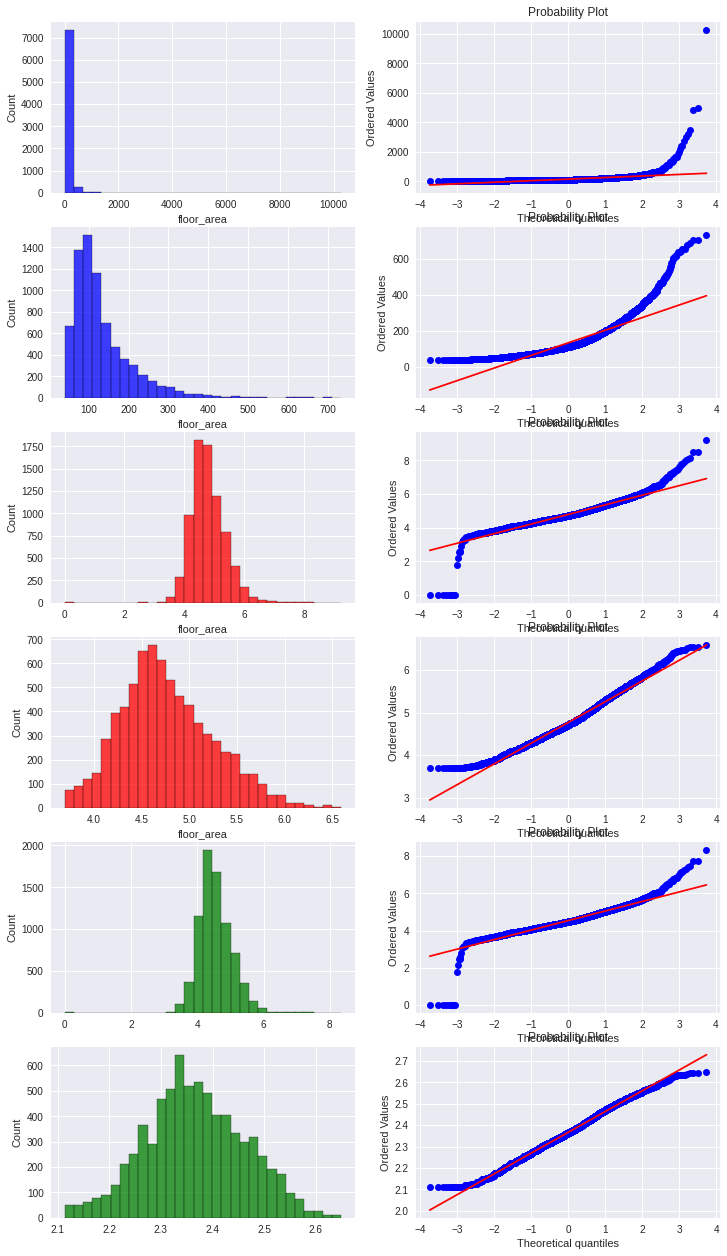

In [45]:
check_transformations(sale, sale_out, 'floor_area')

#### Views Outliers Elimination Results

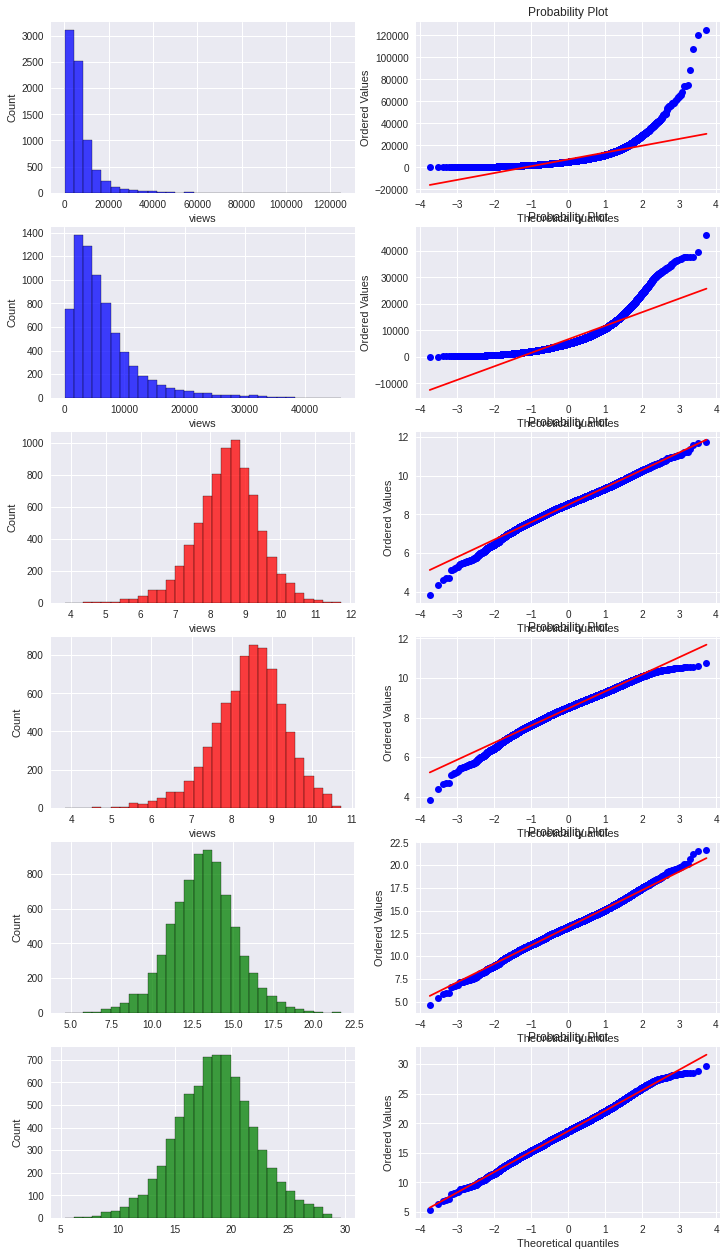

In [46]:
check_transformations(sale.loc[sale['views']!=0].copy(), 
                      sale_out.loc[sale_out['views']!=0].copy(), 'views')

#### Bedroom Outliers Elimination Results

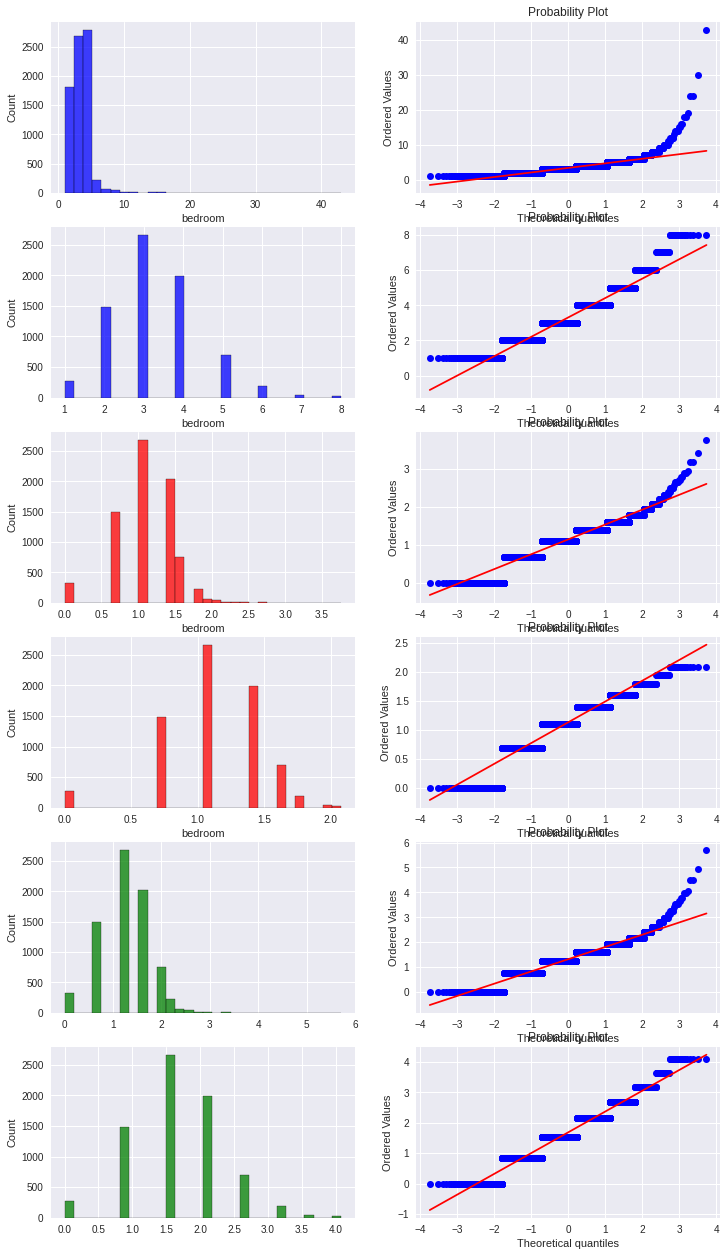

In [47]:
check_transformations(sale, sale_out, 'bedroom')

#### Bathroom Outliers Elimination Results

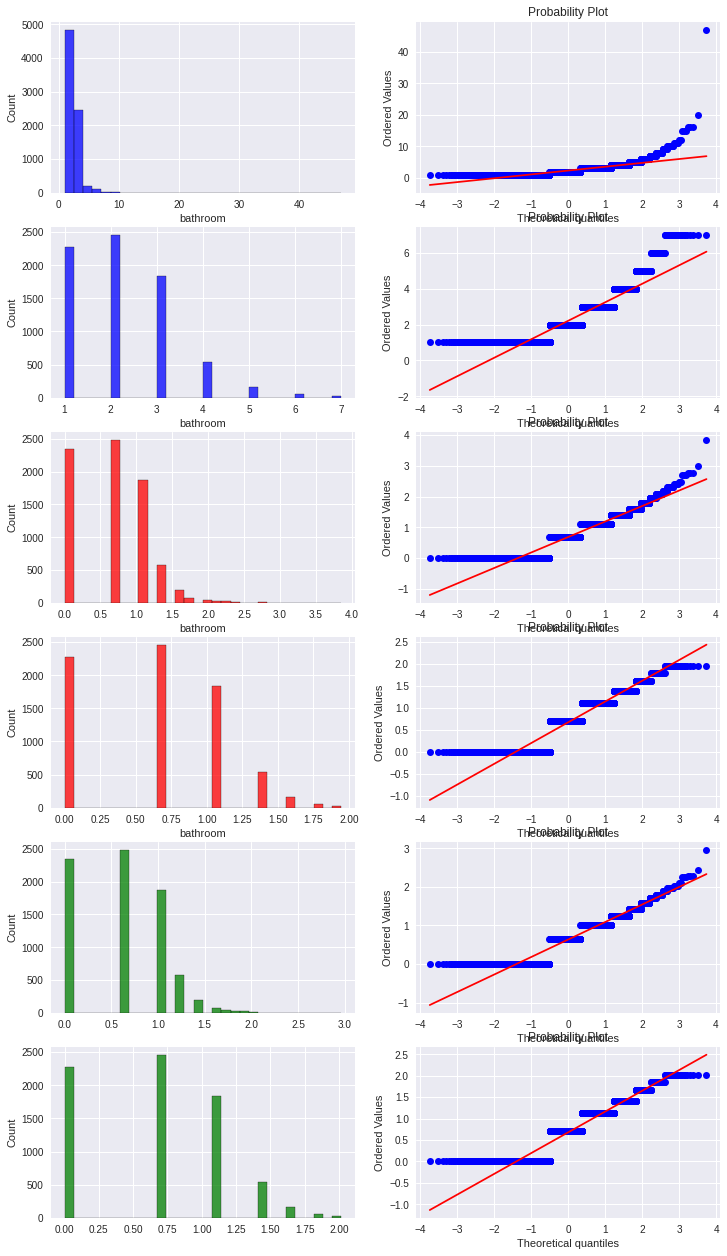

In [48]:
check_transformations(sale, sale_out, 'bathroom')

## Categorical Variables

### Type House

In [49]:
sale_out.type_house.value_counts()

house        5778
apartment    1106
Name: type_house, dtype: int64

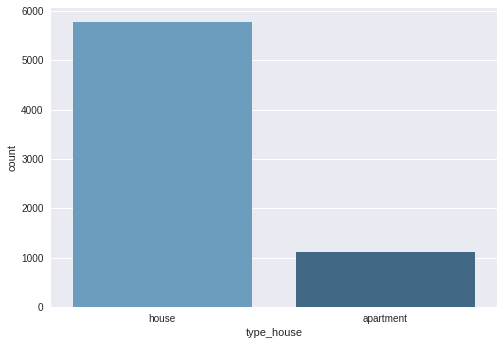

In [50]:
sns.countplot(data=sale_out, x='type_house', palette="Blues_d");

### Ber

In [51]:
sale_out.ber.value_counts()

C3        930
C1        815
C2        808
D1        806
D2        698
B3        578
G         547
E1        456
F         410
E2        343
SI_666    256
B2        220
A3        137
A2        117
B1         70
A1          6
Name: ber, dtype: int64

### Plus Info

In [52]:
sale.plus_info.value_counts()

Detached          2710
Semi-D            1580
Terrace           1145
Apartment         1117
End of Terrace     473
Bungalow           416
Duplex             111
Townhouse          107
House                2
Name: plus_info, dtype: int64

### Place

In [53]:
sale_out.place.value_counts().head()

Cork city southside    270
Galway                 191
Limerick               175
Dublin 4               144
Dublin 18              142
Name: place, dtype: int64

### Postcode and Code

In [54]:
#sale_out.postcode.value_counts()  tiene sentido meterla?

In [55]:
#sale_out.code.value_counts() #no seria lo mismo que place?

### State District

In [56]:
sale_out.state_district.value_counts()

Leinster    4004
Munster     2004
Connacht     965
Name: state_district, dtype: int64

### City_district

In [57]:
sale_out.city_district.value_counts().head()  

Ballincollig - Carrigaline    127
Clondalkin ED                  60
Stillorgan ED                  57
Blanchardstown ED              49
Glencullen ED                  46
Name: city_district, dtype: int64

# Relationships and Feature Selection

## Scatter Plots

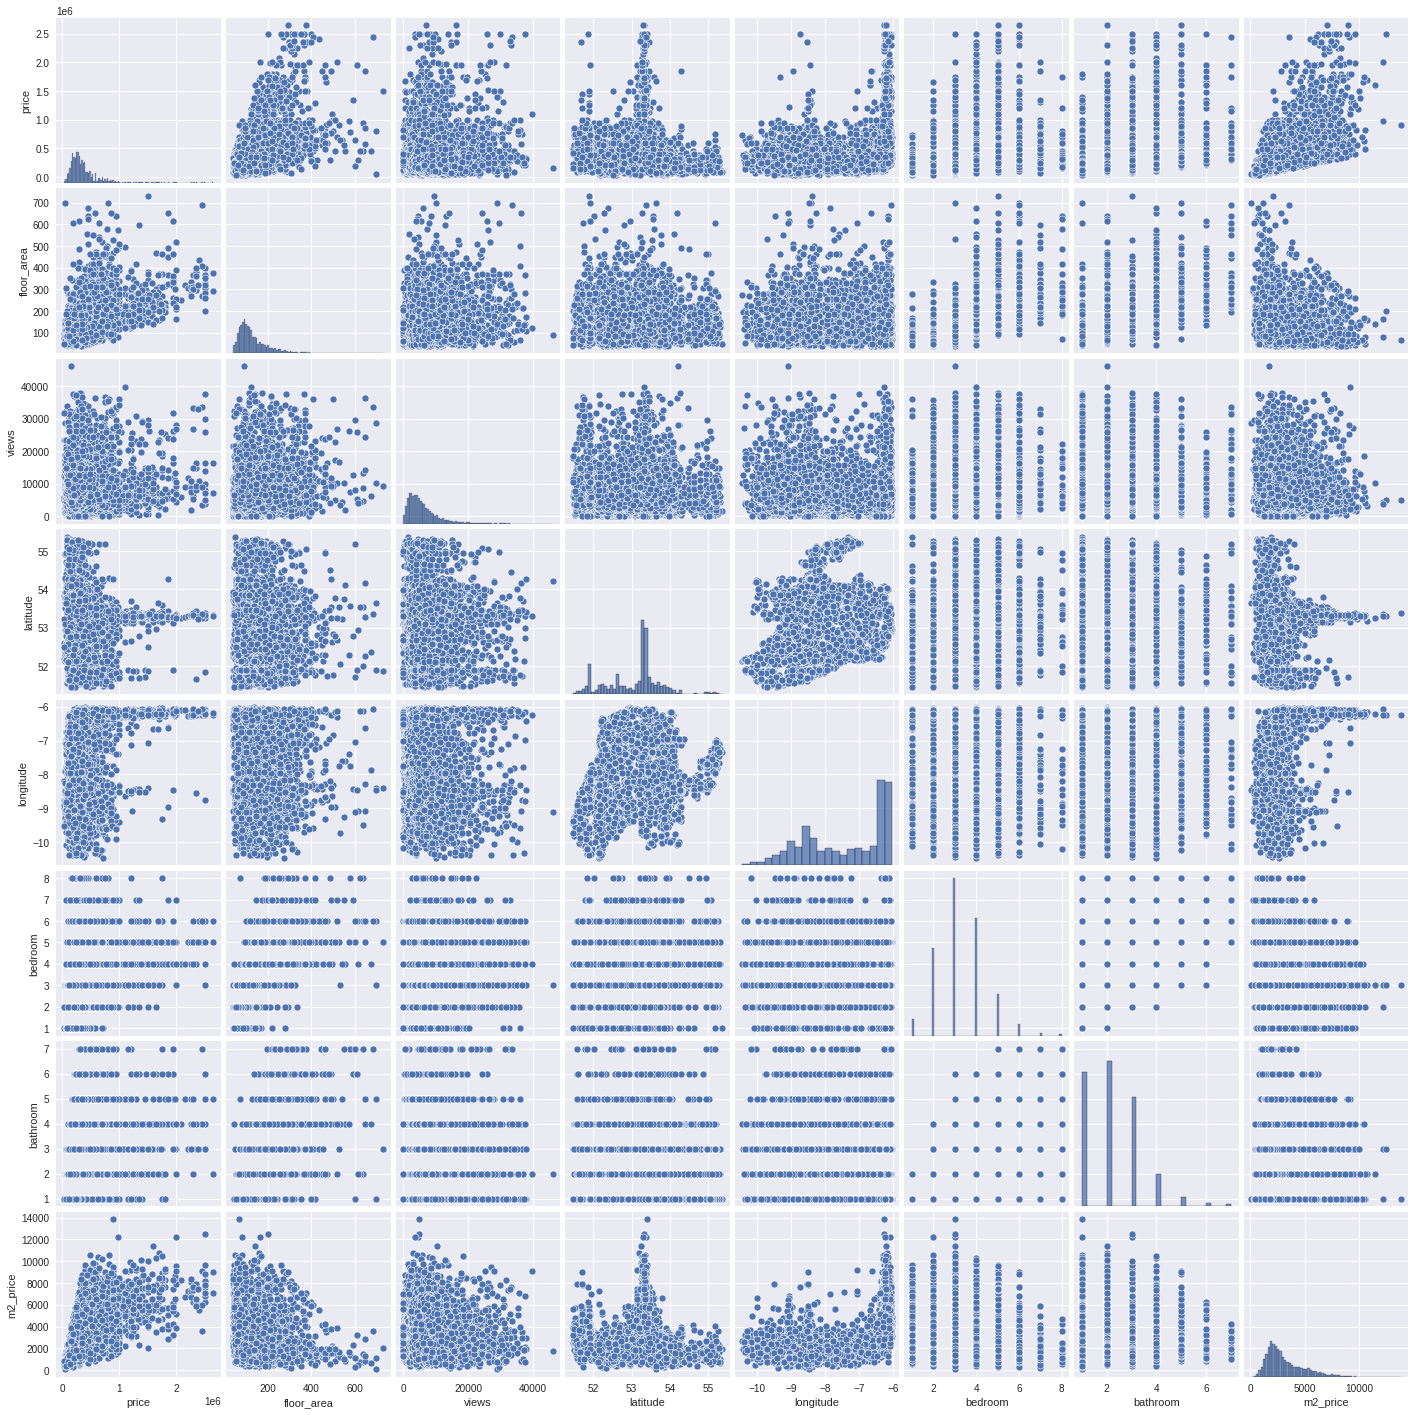

In [58]:
variables = ['price', 
             'floor_area', 
             'views', 
             'latitude', 
             'longitude', 
             'bedroom', 
             'bathroom',  
             'm2_price']

sns.pairplot(sale_out[variables]);

## Correlations

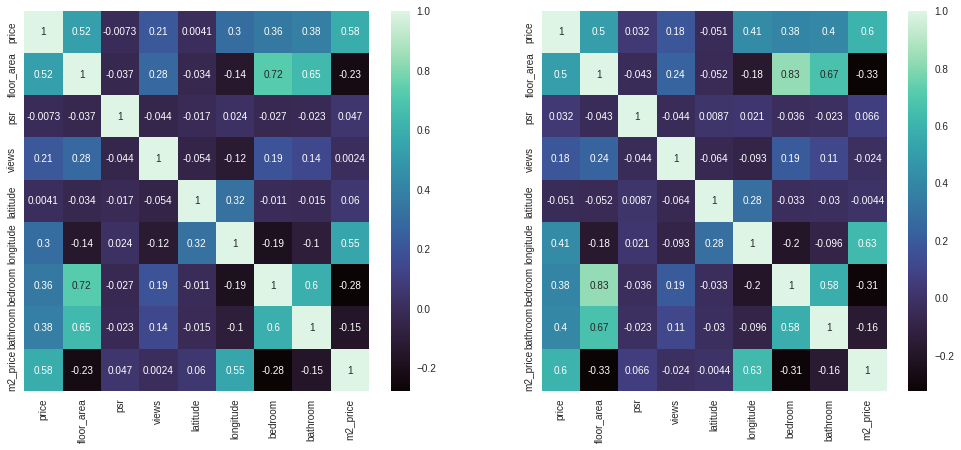

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

sns.heatmap(sale_out.drop(columns=['daft_id']).corr(method='pearson'), 
            annot=True, cmap='mako', ax=axs[0])
sns.heatmap(sale_out.drop(columns=['daft_id']).corr(method='spearman'), 
            annot=True, cmap='mako', ax=axs[1]);

## Predictive Power Score

https://medium.com/towards-data-science/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

In [60]:
variables = ['price', 'sale_type', 'floor_area', 'psr',
       'ber', 'views', 'type_house',
      'latitude', 'longitude', 'bedroom',
       'bathroom', 'plus_info', 'postcode', 'state_district', 'city_district',
       'place', 'code', 'cities', 'm2_price']

In [61]:
pps.predictors(sale_out[variables], 'price', output='df', sorted=True)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,place,price,0.14,regression,True,mean absolute error,186548.09,160907.39,DecisionTreeRegressor()
1,code,price,0.14,regression,True,mean absolute error,186548.09,160907.39,DecisionTreeRegressor()
2,city_district,price,0.14,regression,True,mean absolute error,180320.17,155725.84,DecisionTreeRegressor()
3,postcode,price,0.12,regression,True,mean absolute error,187510.42,164496.93,DecisionTreeRegressor()
4,cities,price,0.08,regression,True,mean absolute error,186548.09,172383.96,DecisionTreeRegressor()
5,psr,price,0.06,regression,True,mean absolute error,177942.92,167081.98,DecisionTreeRegressor()
6,bathroom,price,0.02,regression,True,mean absolute error,177542.98,174651.84,DecisionTreeRegressor()
7,bedroom,price,0.01,regression,True,mean absolute error,177542.98,175891.85,DecisionTreeRegressor()
8,floor_area,price,0.01,regression,True,mean absolute error,177542.98,176506.76,DecisionTreeRegressor()
9,sale_type,price,0.00,regression,True,mean absolute error,177542.98,191604.80,DecisionTreeRegressor()


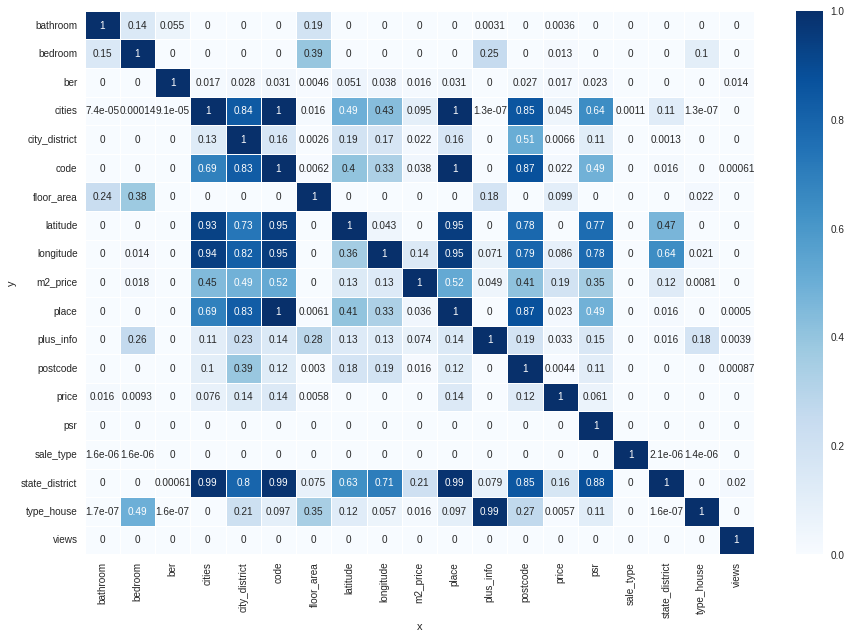

In [62]:
fig, axs = plt.subplots(figsize=(15, 10))
                               
matrix_df = pps.matrix(sale_out[variables])[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True);

## Wrapper Methods

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import (RFE, 
                                       SequentialFeatureSelector)
from sklearn.model_selection import train_test_split

In [169]:
num_features = ['price',
    #'sale_type', 
             'floor_area', 
             'psr',
#             'ber', 
             'views', 
 #            'type_house',
             'latitude', 
             'longitude', 
             'bedroom',
             'bathroom', 
  #           'plus_info', 
   #          'postcode', 
    #         'state_district', 
     #        'city_district',
      #       'place', 
       #      'code', 
        #     'cities', 
             #'m2_price'
            ]


sale_outna = sale_out.dropna().copy()
sale_outna = sale_outna[num_features].copy()

y = sale_outna['price'].copy()
#variables.remove('price')
X = sale_outna.drop(columns='price').copy()
#X = sale_outna1hot.drop(columns='price').copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4064, 7), (1017, 7), (4064,), (1017,))

### Recursive Feature Elimination

Problemas con los nan

In [154]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [171]:
scores_rfe = [] # ahi guardamos los distintos scores que vamos obteniendo
#print(X_train_num.columns, '\n')
for i in range(1, X_train_num.shape[1] + 1): # i = 1,..., 1
    
    lr = LinearRegression()
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    
    rfe = RFE(estimator=lr, 
              n_features_to_select=i, 
              step=1) # i = 1feature, 2features...
    
    rfe.fit(X_train, y_train) # rfe con i features, nos devuelve las i mejores features
    # rfe.fit() selecciona las variables, pero no ajusta el modelo
    
    #print(rfe.support_)
    #print(rfe.ranking_)
    print(X_train.columns[rfe.support_].values, '\n')
    
    lr.fit(X_train.loc[:, rfe.support_], y_train) #rfe.support_ para seleccionar las features-columnas
    # estamos entrenando el modelo con las features q nos proporciona el objeto RFE
    scores_rfe.append(lr.score(X_test.loc[:, rfe.support_], y_test)) 
    # predecimos sobre el dataset de test con las mismas features que hemos entrenado
    
scores_rfe

['bedroom'] 

['longitude' 'bedroom'] 

['longitude' 'bedroom' 'bathroom'] 

['latitude' 'longitude' 'bedroom' 'bathroom'] 

['floor_area' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

['floor_area' 'views' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

['floor_area' 'psr' 'views' 'latitude' 'longitude' 'bedroom' 'bathroom'] 



[0.15117730365562687,
 0.26196482915142016,
 0.3215501291512265,
 0.324257104074274,
 0.47038383172688614,
 0.4780660325229711,
 0.47808355238440037]

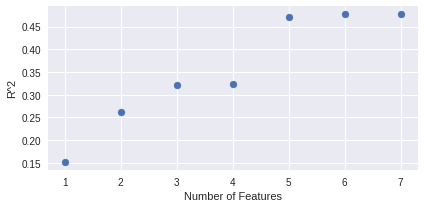

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1] + 1), scores_rfe) # x=1a13, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

### Forward Feature Selection

In [173]:
scores_sfs_forward = [] # ahi guardamos los distintos scores que vamos obteniendo
#print(X_train_num.columns)
for i in range(1, X_train.shape[1]): # i = 1,..., 12
    # este no quiere que le selecciones tantas features como tenga el dataset, quiere menos
    lr = LinearRegression()
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    
    sfs = SequentialFeatureSelector(estimator=lr, 
                                    n_features_to_select=i, 
                                    direction='forward') 
    sfs.fit(X_train, y_train)    
    
    #print(sfs.support_)
    #print(sfs.ranking_)
    print(X_train.columns[sfs.support_].values, '\n')
    
    lr.fit(X_train.loc[:, sfs.support_], y_train)
    
    scores_sfs_forward.append(lr.score(X_test.loc[:, sfs.support_], 
                               y_test)) 
    
scores_sfs_forward

['floor_area'] 

['floor_area' 'longitude'] 

['floor_area' 'views' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude' 'bedroom'] 

['floor_area' 'psr' 'views' 'latitude' 'longitude' 'bedroom'] 



[0.32545353896235485,
 0.4678752635740502,
 0.4752483775503298,
 0.47431144932490255,
 0.4738840769554704,
 0.4739006078887875]

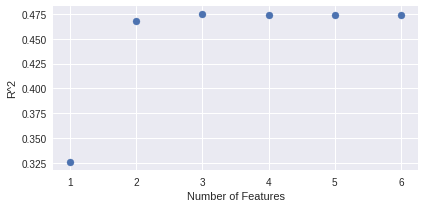

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1]), scores_sfs_forward) # x=1a12, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

### Backward Feature Elimination

In [175]:
scores_sfs_backward = [] # ahi guardamos los distintos scores que vamos obteniendo
#print(X_train_num.columns)
for i in range(1, X_train_num.shape[1]): # i = 1,..., 12
    # este no quiere que le selecciones tantas features como tenga el dataset, quiere menos
    lr = LinearRegression()
    dtr = DecisionTreeRegressor()
    rfr = RandomForestRegressor()
    
    sfs = SequentialFeatureSelector(estimator=dt,  #lr, 
                                    n_features_to_select=i, 
                                    direction='backward',
                                   ) 
    sfs.fit(X_train, y_train)    
    
    #print(sfs.support_)
    #print(sfs.ranking_)
    print(X_train.columns[sfs.support_].values, '\n')
    
    #lr.fit(X_train_num.loc[:, sfs.support_], y_train)
    dt.fit(X_train.loc[:, sfs.support_], y_train)
    
    #scores_sfs_backward.append(lr.score(X_test_num.loc[:, sfs.support_], 
     #                          y_test)) 
    scores_sfs_backward.append(dt.score(X_test.loc[:, sfs.support_], 
                               y_test)) 
    
scores_sfs_backward

['floor_area'] 

['floor_area' 'longitude'] 

['floor_area' 'latitude' 'longitude'] 

['floor_area' 'latitude' 'longitude' 'bedroom'] 

['floor_area' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

['floor_area' 'psr' 'latitude' 'longitude' 'bedroom' 'bathroom'] 



[0.21279335735174154,
 0.4688982568461878,
 0.6416984435155915,
 0.6074186382069807,
 0.609544507443668,
 0.6364520230230073]

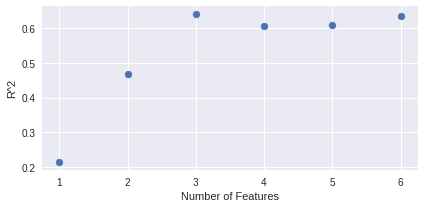

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1]), scores_sfs_backward) # x=1a12, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

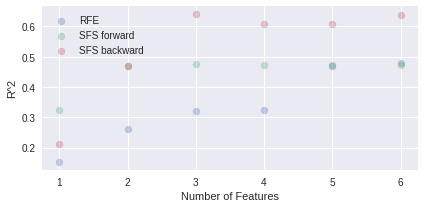

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train.shape[1]), scores_rfe[:-1], label='RFE', alpha=.3) # le quitamos la ultima muestra
ax.scatter(range(1, X_train.shape[1]), scores_sfs_forward, label='SFS forward', alpha=.3)
ax.scatter(range(1, X_train.shape[1]), scores_sfs_backward, label='SFS backward', alpha=.3)

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
ax.legend()
plt.tight_layout()

## *SelectKBest* Feature Selection Strategy

### F Value in Regression

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [179]:
#y = sale_outna['price'].copy()
#X = sale_outna[['floor_area',
 #               'views','latitude',
  #              'longitude',
   #             'bedroom',
    #            'bathroom']].copy()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4064, 7), (1017, 7), (4064,), (1017,))

In [180]:
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

In [183]:
X_train_fs, X_test_fs, fs = select_features(X_train=X_train, y_train=y_train, X_test=X_test)

In [184]:
fs.scores_

array([2029.8834421 ,    2.29060311,  321.29145386,   45.30261451,
        381.93944835,  808.1316851 ,  785.80925435])

In [185]:
for i, feature in zip(range(len(fs.scores_)), fs.get_feature_names_out()):
	print('%s: %f' % (feature, fs.scores_[i]))

AttributeError: 'SelectKBest' object has no attribute 'get_feature_names_out'

In [186]:
plt.bar(fs.get_feature_names_out(), fs.scores_);

AttributeError: 'SelectKBest' object has no attribute 'get_feature_names_out'

In [187]:
f_regression(X_train, y_train)[0] # F score
f_regression(X_train, y_train)[1] # p-values

array([0.00000000e+000, 1.30237136e-001, 3.29549471e-069, 1.92429317e-011,
       2.30674189e-081, 2.77103587e-162, 3.16172794e-158])

In [188]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_regression at 0x7fbb89320a70>)

In [189]:
fs.scores_

array([2029.8834421 ,    2.29060311,  321.29145386,   45.30261451,
        381.93944835,  808.1316851 ,  785.80925435])

In [190]:
for p in fs.pvalues_:
    print(round(p, 6))

0.0
0.130237
0.0
0.0
0.0
0.0
0.0


### Mutual Information

In [191]:
from sklearn.feature_selection import mutual_info_regression

In [192]:
def select_features(X_train, y_train, X_test, score_func):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

In [193]:
X_train_fs, X_test_fs, fs = select_features(X_train=X_train, y_train=y_train, X_test=X_test, 
                                            score_func=mutual_info_regression)

In [194]:
plt.bar(fs.get_feature_names_out(), fs.scores_);

AttributeError: 'SelectKBest' object has no attribute 'get_feature_names_out'

In [195]:
fs.scores_

array([0.2662091 , 0.14727201, 0.04391833, 0.26207378, 0.23820123,
       0.12447052, 0.11089958])

## ANOVA

Let's study first the variables `place` and `price`.

- `place`: Categorical variable with more than three groups (138 groups) -> One-way ANOVA
- `price`: Numerical variaable

The hipothess will be:

* Null Hypothesis, H0: There is no significant difference between the mean `price` among different groups of `place`.
* Alternate Hypothesis, H1: There is a significant difference between the mean `price` among different groups of `place`.

In [ ]:
sale_data_out.isna().sum()

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
sale_data_out[['type_house',
                'postcode',
                'state_district',
                'city_district',
                'county',
                'road',
                'place',
                'code']].isna().sum()

In [ ]:
cat_features = ['type_house',
                'postcode',
                'state_district',
                'city_district',
                'county',
                'road',
                'place',
                'code']

def split_data_cat(data, cat_features, target='price'):

    y = data[target].copy()
    X = data[cat_features].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_data_cat(data=sale_data_out, 
                      cat_features=['type_house',
                                    'postcode',
                                    'state_district',
                                    'city_district',
                                    'county',
                                    'road',
                                    'place',
                                    'code'], 
                      target='price')

In [ ]:
X_train.columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X_train.type_house)
le.classes_

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cols = ['type_house',
        'postcode',
        'state_district',
        'city_district',
        'county',
        'road',
        'place',
        'code']


for column in cols:
    X_train[column] = le.fit_transform(X_train[column])

In [ ]:
X_train[cols].columns

In [ ]:
X_train[cols].head()

In [ ]:
f_classif(X_train[['type_house']], y_train)

In [ ]:
for feature in cols:
    f_value, p_value = f_classif(X_train[[feature]], y_train)
    print(f'{feature}: f_value = {round(f_value[0], 4)}, p_value = {round(p_value[0], 4)}')

In [ ]:
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

# Clustering the Data